In [1]:
%pip install -U lightgbm==3.3.2
%pip install tqdm


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install implicit

Note: you may need to restart the kernel to use updated packages.


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [6]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
# sys.path.append("/content/drive/MyDrive/HM-new/") # path to the `src`` folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [7]:
from src.data import DataHelper
from src.data.metrics import map_at_k, hr_at_k, recall_at_k

from src.retrieval.rules import (
    OrderHistory,
    OrderHistoryDecay,
    ItemPair,
    UserGroupTimeHistory,
    UserGroupSaleTrend,
    TimeHistory,
    TimeHistoryDecay,
    SaleTrend,
    OutOfStock,
)
from src.retrieval.collector import RuleCollector

from src.features import full_sale, week_sale, repurchase_ratio, popularity, period_sale

from src.utils import (
    calc_valid_date,
    merge_week_data,
    reduce_mem_usage,
    calc_embd_similarity,
)

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thangndk67/h-and-m-csv-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/codespace/.cache/kagglehub/datasets/thangndk67/h-and-m-csv-dataset/versions/5


In [9]:
data_dir = Path("data")
model_dir = Path("models")

In [10]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2

VERSION_NAME = "Recall 1"
TEST = True # * Set as `False` when do local experiments to save time

In [11]:
from pathlib import Path
# Ensure base data dir exists, then create interim/processed subfolders
data_dir.mkdir(parents=True, exist_ok=True)
model_dir.mkdir(parents=True, exist_ok=True)
(data_dir / "interim" / VERSION_NAME).mkdir(parents=True, exist_ok=True)
(data_dir / "processed" / VERSION_NAME).mkdir(parents=True, exist_ok=True)

Pepare data: encoding ids and preprocessing

In [12]:
dh = DataHelper(data_dir,raw_dir=path)

In [13]:
data = dh.preprocess_data(save=True, name="encoded_full") # * run only once, processed data will be saved

Encode Item Sparse Feats: 100%|██████████| 12/12 [00:00<00:00, 28.55it/s]


In [14]:
data = dh.load_data(name="encoded_full")

In [15]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(f"{path}/sample_submission.csv")
submission['customer_id'] = submission['customer_id'].map(uid2idx)

## Retrieval


Generate candidates for each week

In [ ]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)

: 

In [ ]:
# * WEEK_NUM = 0: test
# * WEEK_NUM = 1: valid
# * WEEK_NUM > 1: train
for week in range(1,WEEK_NUM):
    # * use sliding window to generate candidates
    if week == 0 and not TEST:
        continue
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")
    
    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    last_week = train.loc[train.t_dat >= last_week_start]
    
    last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
    last_3day_start = last_3day_start.strftime("%Y-%m-%d")
    last_3days = train.loc[train.t_dat >= last_3day_start]

    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            OrderHistory(train, days=3, name='1'),
            OrderHistory(train, days=7, name='2'),
            OrderHistoryDecay(train, days=3, n=50, name='1'),
            OrderHistoryDecay(train, days=7, n=50, name='2'),
            ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
            ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
            ItemPair(OrderHistoryDecay(train, days=3, n=50).retrieve(), name='3'),
            ItemPair(OrderHistoryDecay(train, days=7, n=50).retrieve(), name='4'),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, name='1'),
            UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50, name='2'),
            UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=50),
            TimeHistory(customer_list, last_week, n=50, name='1'),
            TimeHistory(customer_list, last_3days, n=50, name='2'),
            TimeHistoryDecay(customer_list, train, days=3, n=50, name='1'),
            TimeHistoryDecay(customer_list, train, days=7, n=50, name='2'),
            SaleTrend(customer_list, train, days=7, n=50),
            
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.006,
        compress=False,
    )

    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

Week 1: [2020-09-16, 2020-09-23)


In [ ]:
# * use the threshold in week 1 to generate candidates for test data, see the log in the upper cell 
if TEST:
    week = 0
    trans = data["inter"]
    
    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")
    
    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    last_week = train.loc[train.t_dat >= last_week_start]
    
    last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
    last_3day_start = last_3day_start.strftime("%Y-%m-%d")
    last_3days = train.loc[train.t_dat >= last_3day_start]

    customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            OrderHistory(train, days=3, name='1'),
            OrderHistory(train, days=7, name='2'),
            OrderHistoryDecay(train, days=3, n=50, name='1'),
            OrderHistoryDecay(train, days=7, n=50, name='2'),
            ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
            ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
            ItemPair(OrderHistoryDecay(train, days=3, n=50).retrieve(), name='3'),
            ItemPair(OrderHistoryDecay(train, days=7, n=50).retrieve(), name='4'),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, name='1'),
            UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50, name='2'),
            UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=50),
            TimeHistory(customer_list, last_week, n=50, name='1'),
            TimeHistory(customer_list, last_3days, n=50, name='2'),
            TimeHistoryDecay(customer_list, train, days=3, n=50, name='1'),
            TimeHistoryDecay(customer_list, train, days=7, n=50, name='2'),
            SaleTrend(customer_list, train, days=7, n=50),
        
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.006,
        compress=False,
    )
    
    candidates, _ = reduce_mem_usage(candidates)
    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

Week 0: [2020-09-23, 2020-09-30)


KeyboardInterrupt: 

In [ ]:
del train, valid, last_week, customer_list, candidates
gc.collect()

## Feature engineering


In [ ]:
user = data["user"]
item = data["item"]
inter = data["inter"]

In [ ]:
# calculate week number
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7

: 

In [ ]:
# merge full candidates to transaction data (avoid feature missing in training data)
full_candidates = []
for i in tqdm(range(WEEK_NUM)):
    candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
    full_candidates += candidate['article_id'].values.tolist()
full_candidates = list(set(full_candidates))
del candidate
gc.collect()

num_candidates = len(full_candidates)
full_candidates = np.array(full_candidates)
full_candidates = np.tile(full_candidates, WEEK_NUM + 1)
weeks = np.repeat(np.arange(1,WEEK_NUM+2), num_candidates)
full_candidates = pd.DataFrame({'article_id':full_candidates, 'week':weeks})

inter['valid'] = 1
in_train = inter[inter['week']<=WEEK_NUM + 1]
out_train = inter[inter['week']>WEEK_NUM + 1]

in_train = in_train.merge(full_candidates, on=['article_id','week'], how='right')
in_train['valid'] = in_train['valid'].fillna(0)
inter = pd.concat([in_train, out_train], ignore_index=True)
inter = inter.sort_values(["valid"], ascending=False).reset_index(drop=True)

100%|██████████| 6/6 [00:01<00:00,  3.33it/s]


3851

In [ ]:
# merge `product_code`
inter = inter.merge(item[["article_id", "product_code"]], on="article_id", how="left")

In [ ]:
inter.shape

(31837313, 8)

In [ ]:
_, inter["i_1w_sale_rank"], inter["i_1w_sale_norm"] = period_sale(
    inter, ["article_id"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
_, inter["p_1w_sale_rank"], inter["p_1w_sale_norm"] = period_sale(
    inter, ["product_code"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_2w_sale"], inter["i_2w_sale_rank"], inter["i_2w_sale_norm"] = period_sale(
    inter, ["article_id"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_2w_sale"], inter["p_2w_sale_rank"], inter["p_2w_sale_norm"] = period_sale(
    inter, ["product_code"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)

In [ ]:
inter["i_3w_sale"], inter["i_3w_sale_rank"], inter["i_3w_sale_norm"] = period_sale(
    inter, ["article_id"], days=21, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_3w_sale"], inter["p_3w_sale_rank"], inter["p_3w_sale_norm"] = period_sale(
    inter, ["product_code"], days=21, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_4w_sale"], inter["i_4w_sale_rank"], inter["i_4w_sale_norm"] = period_sale(
    inter, ["article_id"], days=28, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_4w_sale"], inter["p_4w_sale_rank"], inter["p_4w_sale_norm"] = period_sale(
    inter, ["product_code"], days=28, rank=True, norm=True, week_num=WEEK_NUM
)

In [ ]:
inter.shape

(31837313, 30)

In [ ]:
inter['i_repurchase_ratio'] = repurchase_ratio(inter, ['article_id'], week_num=WEEK_NUM)
inter['p_repurchase_ratio'] = repurchase_ratio(inter, ['product_code'], week_num=WEEK_NUM)

100%|██████████| 6/6 [02:00<00:00, 20.07s/it]


In [ ]:
inter.shape

(31837313, 32)

In [ ]:
inter, _ = reduce_mem_usage(inter)

In [ ]:
inter["i_sale"] = week_sale(inter, ["article_id"], week_num=WEEK_NUM)
inter["p_sale"] = week_sale(inter, ["product_code"], week_num=WEEK_NUM)
inter["i_sale_uni"] = week_sale(inter, ["article_id"], True, week_num=WEEK_NUM)
inter["p_sale_uni"] = week_sale(inter, ["product_code"], True, week_num=WEEK_NUM)
inter["lw_i_sale"] = week_sale(inter, ["article_id"], step=1, week_num=WEEK_NUM) # * last week sale
inter["lw_p_sale"] = week_sale(inter, ["product_code"], step=1, week_num=WEEK_NUM)
inter["lw_i_sale_uni"] = week_sale(inter, ["article_id"], True, step=1, week_num=WEEK_NUM)
inter["lw_p_sale_uni"] = week_sale(inter, ["product_code"], True, step=1, week_num=WEEK_NUM)

inter["i_sale_ratio"] = inter["i_sale"] / (inter["p_sale"] + 1e-6)
inter["i_sale_uni_ratio"] = inter["i_sale_uni"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_sale_ratio"] = inter["lw_i_sale"] / (inter["lw_p_sale"] + 1e-6)
inter["lw_i_sale_uni_ratio"] = inter["lw_i_sale_uni"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_uni_ratio"] = inter["i_sale"] / (inter["i_sale_uni"] + 1e-6)
inter["p_uni_ratio"] = inter["p_sale"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_uni_ratio"] = inter["lw_i_sale"] / (inter["lw_i_sale_uni"] + 1e-6)
inter["lw_p_uni_ratio"] = inter["lw_p_sale"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_sale_trend"] = (inter["i_sale"] - inter["lw_i_sale"]) / (inter["lw_i_sale"] + 1e-6)
inter["p_sale_trend"] = (inter["p_sale"] - inter["lw_p_sale"]) / (inter["lw_p_sale"] + 1e-6)

item_feats = [
    "product_type_no",
    # "product_group_name",
    # "graphical_appearance_no",
    # "colour_group_code",
    # "perceived_colour_value_id",
    # "perceived_colour_master_id",
]
inter = inter.merge(item[["article_id", *item_feats]], on="article_id", how="left")

for f in tqdm(item_feats):
    inter[f"{f}_sale"] = week_sale(inter, [f], f"{f}_sale", week_num=WEEK_NUM)
    inter[f"lw_{f}_sale"] = week_sale(inter, [f], f"{f}_sale", step=1, week_num=WEEK_NUM)
    inter[f"{f}_sale_trend"] = (inter[f"{f}_sale"] - inter[f"lw_{f}_sale"]) / (inter[f"lw_{f}_sale"] + 1e-6)

100%|██████████| 1/1 [00:22<00:00, 22.43s/it]


In [ ]:
inter.shape

(31837313, 54)

In [ ]:
# * Date related
curr_date_dict = {x:calc_valid_date(x-1)[0] for x in range(100)}
current_dat = inter['week'].map(curr_date_dict)
mask = inter['valid']==0
inter.loc[mask, 't_dat'] = inter.loc[mask, 'week'].map(curr_date_dict)
first_date = inter.groupby('article_id')['t_dat'].min().reset_index(name='first_dat')
inter = pd.merge(inter, first_date, on='article_id', how='left')
# df = pd.merge(df, last_date, on='article_id', how='left')
inter['first_dat'] = (pd.to_datetime(current_dat)-pd.to_datetime(inter['first_dat'])).dt.days

In [ ]:
inter.shape

(31837313, 55)

In [ ]:
inter['i_full_sale'] = full_sale(inter, ['article_id'], week_num=WEEK_NUM)
inter['p_full_sale'] = full_sale(inter, ['product_code'], week_num=WEEK_NUM)

inter['i_daily_sale'] = inter['i_full_sale'] / inter['first_dat']
inter['p_daily_sale'] = inter['p_full_sale'] / inter['first_dat']
inter['i_daily_sale_ratio'] = inter['i_daily_sale'] / inter['p_daily_sale']
inter['i_w_full_sale_ratio'] = inter['i_sale'] / inter['i_full_sale']

inter['i_2w_full_sale_ratio'] = inter['i_2w_sale'] / inter['i_full_sale']
inter['p_w_full_sale_ratio'] = inter['p_sale'] / inter['p_full_sale']
inter['p_2w_full_sale_ratio'] = inter['p_2w_sale'] / inter['p_full_sale']

inter['i_week_above_daily_sale'] = inter['i_sale'] / 7 - inter['i_daily_sale']
inter['p_week_above_full_sale'] = inter['p_sale'] / 7 - inter['i_full_sale']
inter['i_2w_week_above_daily_sale'] = inter['i_2w_sale'] / 14 - inter['i_daily_sale']
inter['p_2w_week_above_daily_sale'] = inter['p_2w_sale'] / 14 - inter['p_daily_sale']

In [ ]:
gc.collect()

94

In [ ]:
for f in tqdm(item_feats):
    inter[f'{f}_full_sale'] = full_sale(inter, [f], week_num=WEEK_NUM)
    f_first_date = inter.groupby(f)['t_dat'].min().reset_index(name=f'{f}_first_dat')
    inter = inter.merge(f_first_date, on=f, how='left')
    inter[f'{f}_daily_sale'] = inter[f'{f}_full_sale'] / (pd.to_datetime(current_dat) - pd.to_datetime(inter[f'{f}_first_dat'])).dt.days
    inter[f'i_{f}_daily_sale_ratio'] = inter['i_daily_sale'] / inter[f'{f}_daily_sale']
    inter[f'p_{f}_daily_sale_ratio'] = inter['p_daily_sale'] / inter[f'{f}_daily_sale']
    del inter[f'{f}_full_sale'], inter[f'{f}_first_dat']
    gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

17

100%|██████████| 1/1 [01:21<00:00, 81.40s/it]


In [ ]:
for f in item_feats + ['i_full_sale','p_full_sale']:
    del inter[f]

In [ ]:
inter['i_pop'] = popularity(inter, 'article_id', week_num=WEEK_NUM)
inter['p_pop'] = popularity(inter, 'product_code', week_num=WEEK_NUM)

In [ ]:
inter = inter.loc[inter['week'] <= WEEK_NUM + 2]

In [ ]:
inter.to_parquet(data_dir / "processed/processed_inter.pqt")

## Merge Features


In [ ]:
inter = pd.read_parquet(data_dir / "processed/processed_inter.pqt")
inter = inter[inter['week'] <= WEEK_NUM + 2]

In [ ]:
def try_load(path):
    try:
        return np.load(path, allow_pickle=True)
    except Exception:
        return None

dssm_user_embd = try_load(data_dir / "external" / "dssm_user_embd.npy")
dssm_item_embd = try_load(data_dir / "external" / "dssm_item_embd.npy")
yt_user_embd = try_load(data_dir / "external" / "yt_user_embd.npy")
yt_item_embd = try_load(data_dir / "external" / "yt_item_embd.npy")
w2v_user_embd = try_load(data_dir / "external" / "w2v_user_embd.npy")
w2v_item_embd = try_load(data_dir / "external" / "w2v_item_embd.npy")


#* embeddings from DSSM model
# dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
# dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)
# # * embeddings from YouTubeDNN model
# yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
# yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)
# # * embeddings from Word2Vector model
# w2v_user_embd = np.load(data_dir/'external'/'w2v_user_embd.npy', allow_pickle=True)
# w2v_item_embd = np.load(data_dir/'external'/'w2v_item_embd.npy', allow_pickle=True)

In [ ]:
for col in inter.columns:
    inter[col] = np.nan_to_num(inter[col])

In [ ]:
for i in tqdm(range(WEEK_NUM)):
    if i == 0 and not TEST:
        continue
    candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
    if i == 0:
        chunk_size = int(candidate.shape[0] * 0.5)
        for chunk,batch in enumerate(range(0, candidate.shape[0], chunk_size)):
            sub_candidate = candidate.iloc[batch:batch+chunk_size-1]
            # * merge features
            sub_candidate = merge_week_data(data, inter, i, sub_candidate)
            sub_candidate['article_id'] = sub_candidate['article_id'].astype(int)
            sub_candidate['customer_id'] = sub_candidate['customer_id'].astype(int)
            # * merge DSSM user and item embeddings
            sub_candidate["dssm_similarity"] = calc_embd_similarity(sub_candidate, dssm_user_embd, dssm_item_embd)
            # * merge YouTubeDNN user and item embeddings
            sub_candidate["yt_similarity"] = calc_embd_similarity(sub_candidate, yt_user_embd, yt_item_embd)
            # * merge Word2Vector user and item embeddings
            sub_candidate["wv_similarity"] = calc_embd_similarity(sub_candidate, w2v_user_embd, w2v_item_embd, sub=False)
            print(f"Chunk {chunk} done...")
            sub_candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate_{chunk}.pqt")
    else:
        # * merge features
        candidate = merge_week_data(data, inter, i, candidate)
        print(candidate['week'].unique())
        # * merge DSSM user and item embeddings
        candidate["dssm_similarity"] = calc_embd_similarity(candidate, dssm_user_embd, dssm_item_embd)
        # * merge YouTubeDNN user and item embeddings
        candidate["yt_similarity"] = calc_embd_similarity(candidate, yt_user_embd, yt_item_embd)
        candidate["wv_similarity"] = calc_embd_similarity(candidate, w2v_user_embd, w2v_item_embd, sub=False)
    candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")

100%|██████████| 2766/2766 [00:10<00:00, 258.02it/s]

100%|██████████| 2766/2766 [00:10<00:00, 257.38it/s]

100%|██████████| 2766/2766 [00:31<00:00, 87.67it/s] 


Chunk 0 done...



100%|██████████| 2766/2766 [00:11<00:00, 240.03it/s]

100%|██████████| 2766/2766 [00:11<00:00, 242.01it/s]

100%|██████████| 2766/2766 [00:22<00:00, 123.16it/s]


Chunk 1 done...


 17%|█▋        | 1/6 [11:46<58:51, 706.31s/it]

68984
[1]



100%|██████████| 306/306 [00:01<00:00, 183.96it/s]

100%|██████████| 306/306 [00:01<00:00, 208.73it/s]

 33%|███▎      | 2/6 [12:32<21:11, 317.90s/it]

72019
[2]



100%|██████████| 225/225 [00:01<00:00, 199.38it/s]

100%|██████████| 225/225 [00:01<00:00, 220.40it/s]

 50%|█████     | 3/6 [13:06<09:24, 188.17s/it]

75822
[3]



100%|██████████| 280/280 [00:01<00:00, 213.52it/s]

100%|██████████| 280/280 [00:01<00:00, 236.83it/s]

 67%|██████▋   | 4/6 [13:46<04:19, 129.64s/it]

80253
[4]



100%|██████████| 298/298 [00:01<00:00, 207.64it/s]

100%|██████████| 298/298 [00:01<00:00, 222.65it/s]

 83%|████████▎ | 5/6 [14:29<01:38, 98.39s/it] 

72035
[5]



100%|██████████| 178/178 [00:00<00:00, 203.60it/s]

100%|██████████| 178/178 [00:00<00:00, 220.95it/s]

100%|██████████| 6/6 [15:14<00:00, 152.45s/it]


In [ ]:
del dssm_user_embd, dssm_item_embd, yt_user_embd, yt_item_embd
gc.collect()

858

## Ranking


In [ ]:
candidates = {}
labels = {}
for i in tqdm(range(1, WEEK_NUM)):
    candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
    labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")    

100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


In [ ]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",
    ]
]
cat_features = [
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",

    "user_gender",
    "article_gender",
    "season_type"
]

In [ ]:
# * Convert categorical featues as `CategoricalDtype`
cate_dict = {}        
for feat in tqdm(cat_features):
    if feat in data['user'].columns:
        value_set = set(data['user'][feat].unique())
    elif feat in data['item'].columns:
        value_set = set(data['item'][feat].unique())
    else:
        value_set = set(data['inter'][feat].unique())
    cate_dict[feat] = CategoricalDtype(categories=value_set)

100%|██████████| 17/17 [00:00<00:00, 18.68it/s]


In [ ]:
full_data = pd.concat([candidates[i] for i in range(1, WEEK_NUM)], ignore_index=True)

### Extra Features

In [ ]:
inter = data['inter']
inter = inter[inter['t_dat']<'2020-08-19'] # * start date of the last valid week
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7
inter = inter.merge(data['item'][["article_id", "product_code"]], on="article_id", how="left")

In [ ]:
tmp = inter.groupby('article_id').week.mean()
full_data['article_time_mean'] = full_data['article_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(-1)
full_data['customer_id_last_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(0)
full_data['customer_id_first_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.mean()
full_data['customer_id_time_mean'] = full_data['customer_id'].map(tmp)

full_data['customer_id_gap'] = full_data['customer_id_first_time'] - full_data['customer_id_last_time']

In [ ]:
feats += [
    'article_time_mean', 
    'customer_id_last_time', 
    'customer_id_first_time', 
    'customer_id_time_mean',
    'customer_id_gap'
]

In [ ]:
del tmp
gc.collect()

0

In [ ]:
print(feat)

season_type


In [ ]:
print(cat_features)

['customer_id', 'article_id', 'product_code', 'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'product_type_no', 'product_group_name', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id', 'perceived_colour_master_id', 'user_gender', 'article_gender', 'season_type']


### Train


In [ ]:
for feat in tqdm(cat_features):
    full_data[feat] = full_data[feat].astype(cate_dict[feat])

100%|██████████| 17/17 [00:00<00:00, 216.91it/s]


In [ ]:
train = full_data.loc[full_data['week']>1]
valid = full_data.loc[full_data['week']==1]

del full_data
gc.collect()

0

In [ ]:
params = {
    "objective": "binary",#"lambdarank",
    "boosting_type": "gbdt",
    "metric": "auc",#"map",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.03,
    "verbose": -1,
    "eval_at": 12,
}

In [ ]:
def train_rank_model(train, valid, train_group, valid_group):

    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        group=train_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        group=valid_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        "models/lgb_small_ranker.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [ ]:
def train_binary_model(train, valid):

    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        "models/lgb_small_binary.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [ ]:
import os
from pathlib import Path

# Kiểm tra xem file có tồn tại không
model_path = "/H-M-Fashion-RecSys/notebooks/models/lgb_small_binary.model"
if os.path.exists(model_path):
    print("File tồn tại")
else:
    print("File không tồn tại")
    # Liệt kê các file trong thư mục
    model_dir = Path("notebooks/models")
    if model_dir.exists():
        print("Các file trong thư mục:", list(model_dir.glob("*")))

File không tồn tại


In [ ]:
# del candidates
# gc.collect()

In [ ]:
print("Train positive rate:", train.label.mean())

Train positive rate: 0.02508359708885432


In [ ]:
train = train.sort_values(by=["week", "customer_id"], ascending=True).reset_index(drop=True)
valid = valid.sort_values(by=["customer_id"], ascending=True).reset_index(drop=True)

In [ ]:
train_group = train[["customer_id", "article_id", "week"]]
train_group = train_group.astype("int32")  # * convert to int to avoid `0` in groupby count result
train_group = (train_group.groupby(["week", "customer_id"]).size().values)

In [ ]:
valid_group = valid[["customer_id", "article_id"]]
valid_group = valid_group.astype("int32")  # * convert to int to avoid `0` in groupby count result
valid_group = valid_group.groupby(["customer_id"]).size().values

In [ ]:
train = train[feats+['label']]
valid = valid[feats+['label']]

In [ ]:
gc.collect()

0

In [ ]:
print(feats)

['customer_id', 'article_id', 'OrderHistory_1', 'OrderHistory_2', 'price', 'valid', 'product_code', 'i_1w_sale_rank', 'i_1w_sale_norm', 'p_1w_sale_rank', 'p_1w_sale_norm', 'i_2w_sale', 'i_2w_sale_rank', 'i_2w_sale_norm', 'p_2w_sale', 'p_2w_sale_rank', 'p_2w_sale_norm', 'i_3w_sale', 'i_3w_sale_rank', 'i_3w_sale_norm', 'p_3w_sale', 'p_3w_sale_rank', 'p_3w_sale_norm', 'i_4w_sale', 'i_4w_sale_rank', 'i_4w_sale_norm', 'p_4w_sale', 'p_4w_sale_rank', 'p_4w_sale_norm', 'i_repurchase_ratio', 'p_repurchase_ratio', 'i_sale', 'p_sale', 'i_sale_uni', 'p_sale_uni', 'lw_i_sale', 'lw_p_sale', 'lw_i_sale_uni', 'lw_p_sale_uni', 'i_sale_ratio', 'i_sale_uni_ratio', 'lw_i_sale_ratio', 'lw_i_sale_uni_ratio', 'i_uni_ratio', 'p_uni_ratio', 'lw_i_uni_ratio', 'lw_p_uni_ratio', 'i_sale_trend', 'p_sale_trend', 'product_type_no_sale', 'lw_product_type_no_sale', 'product_type_no_sale_trend', 'first_dat', 'i_daily_sale', 'p_daily_sale', 'i_daily_sale_ratio', 'i_w_full_sale_ratio', 'i_2w_full_sale_ratio', 'p_w_full_s

In [ ]:
print(cat_features)

['customer_id', 'article_id', 'product_code', 'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'product_type_no', 'product_group_name', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id', 'perceived_colour_master_id', 'user_gender', 'article_gender', 'season_type']


In [ ]:
# ranker = train_rank_model(train, valid, train_group, valid_group)
ranker = train_binary_model(train, valid)

ValueError: Unable to avoid copy while creating an array as requested.
If using `np.array(obj, copy=False)` replace it with `np.asarray(obj)` to allow a copy when needed (no behavior change in NumPy 1.x).
For more details, see https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword.

### Inference

In [ ]:
# ranker = lgb.Booster(model_file=model_dir / "lgb_small_binary.model")
ranker = lgb.Booster(model_file=f'{path}/lgb_small_binary.model')

In [ ]:
print(f"Số lượng tên features (feats): {len(feats)}")
print(f"Số lượng giá trị importance: {len(ranker.feature_importance())}")

Số lượng tên features (feats): 91
Số lượng giá trị importance: 91


<Figure size 800x2200 with 0 Axes>

<Axes: xlabel='importance', ylabel='feature'>

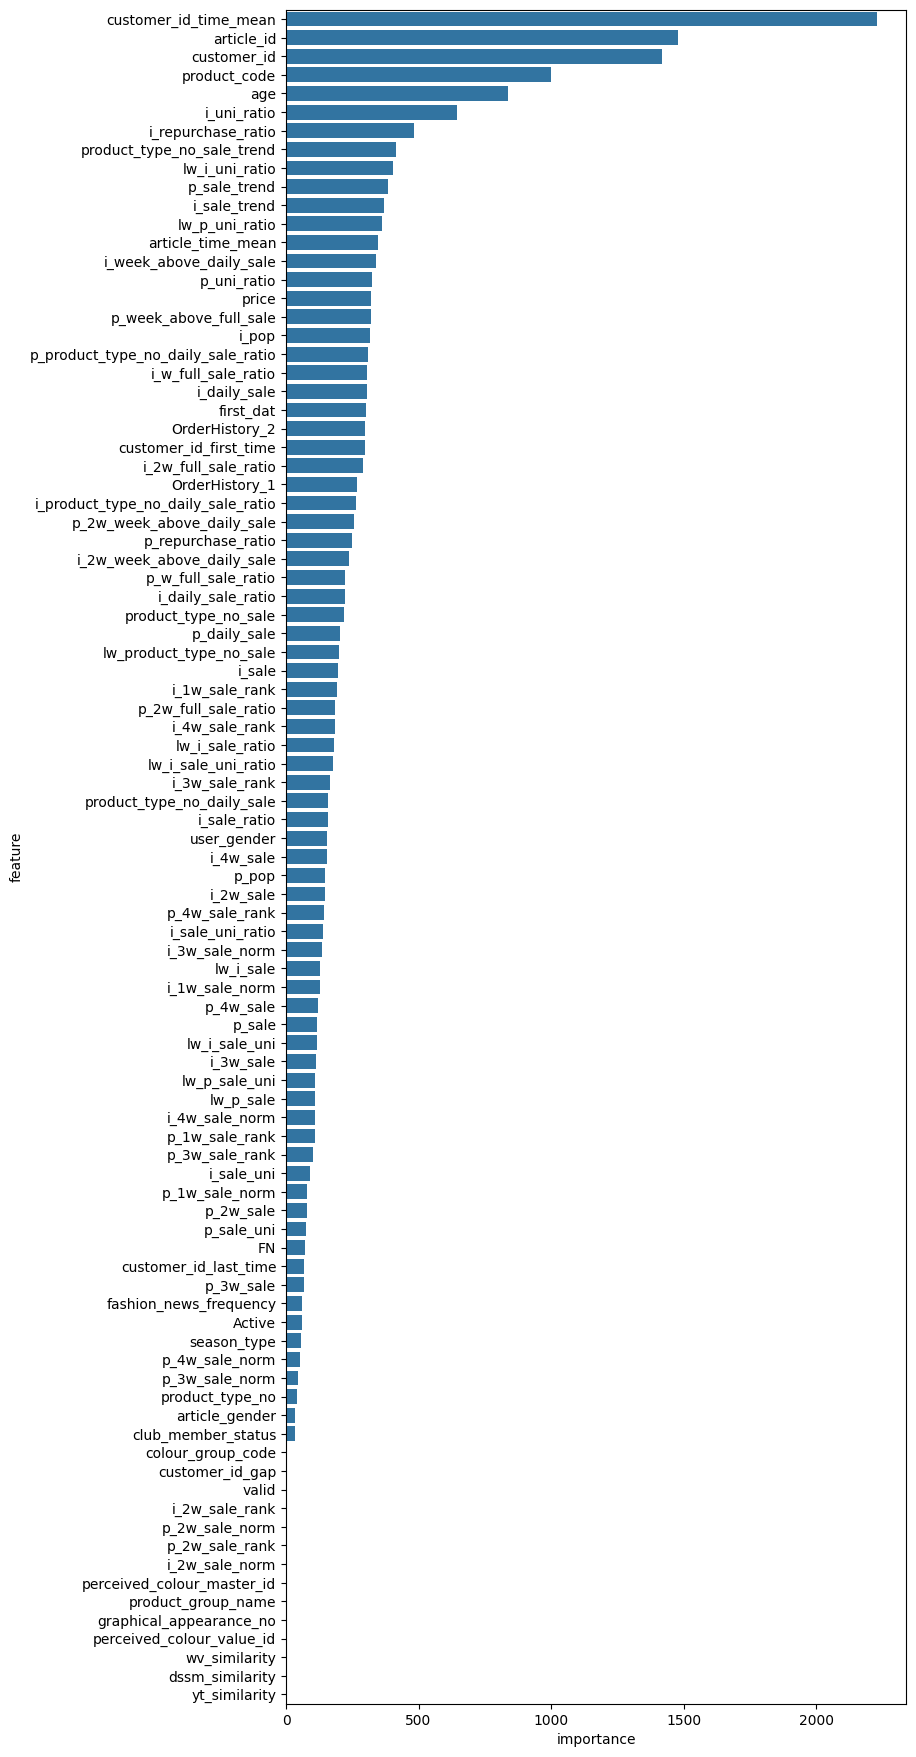

In [ ]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 22))
sns.barplot(y="feature", x="importance", data=feat_importance)

### Validate

In [ ]:
val_candidates = valid.reset_index(drop=True)

In [ ]:
def predict(ranker, candidates, batch_size = 5_000_000):
    probs = np.zeros(candidates.shape[0])
    for batch in range(0, candidates.shape[0], batch_size):
        outputs = ranker.predict(candidates.loc[batch : batch + batch_size - 1, feats])
        probs[batch : batch + batch_size] = outputs
    candidates["prob"] = probs
    pred_lgb = candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()
    return pred_lgb

In [ ]:
pred = predict(ranker, val_candidates)

100%|██████████| 56560/56560 [00:04<00:00, 13469.45it/s]


In [ ]:
label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

In [ ]:
# map_at_k(label["article_id"], label["prediction"], k=12)

def ensure_list(x):
    if isinstance(x, (list, np.ndarray)):
        return x
    elif x is None:
        return []
    else:
        return [x]

# Áp dụng conversion
actual_processed = [ensure_list(x) for x in label["article_id"]]
predicted_processed = [ensure_list(x) for x in label["prediction"]]

# Gọi hàm với dữ liệu đã xử lý
result = map_at_k(actual_processed, predicted_processed, k=12)
print(f"MAP@12: {result}")
# 0.029813727108367518 ranker
# 0.029791925075924913 binary

MAP@12: 0.020956446101406154


In [ ]:
batch_size = 5_000_000
probs = np.zeros(val_candidates.shape[0])
for batch in range(0, val_candidates.shape[0], batch_size):
    outputs = ranker.predict(val_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs
val_candidates["prob"] = probs
pred_lgb = val_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)

In [ ]:
pred_lgb.to_parquet(data_dir/"processed"/"small_binary_valid.pqt")

### Test

In [ ]:
# del candidates
# gc.collect()

In [ ]:
test_pred = []
for chunk in range(2):
    print(f"Chunk {chunk}")
    test_candidates = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week0_candidate_{chunk}.pqt")
    for feat in cat_features:
        test_candidates[feat] = test_candidates[feat].astype(cate_dict[feat])

    # * Extra Features ===================================

    tmp = inter.groupby('article_id').week.mean()
    test_candidates['article_time_mean'] = test_candidates['article_id'].map(tmp)

    tmp = inter.groupby('customer_id').week.nth(-1)
    test_candidates['customer_id_last_time'] = test_candidates['customer_id'].map(tmp)

    tmp = inter.groupby('customer_id').week.nth(0)
    test_candidates['customer_id_first_time'] = test_candidates['customer_id'].map(tmp)

    tmp = inter.groupby('customer_id').week.mean()
    test_candidates['customer_id_time_mean'] = test_candidates['customer_id'].map(tmp)

    test_candidates['customer_id_gap'] = test_candidates['customer_id_first_time'] - test_candidates['customer_id_last_time']

    gc.collect()
    # * ==================================================
    
    batch_size = 5_000_000
    probs = np.zeros(test_candidates.shape[0])
    for batch in tqdm(range(0, test_candidates.shape[0], batch_size)):
        outputs = ranker.predict(test_candidates.loc[batch : batch + batch_size - 1, feats])
        probs[batch : batch + batch_size] = outputs
    test_candidates["prob"] = probs
    pred_lgb = test_candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    test_pred.append(pred_lgb)
    del test_candidates
    gc.collect()

Chunk 0


53

100%|██████████| 6/6 [02:57<00:00, 29.52s/it]


24

Chunk 1


0

100%|██████████| 6/6 [02:26<00:00, 24.38s/it]


4

In [ ]:
pred_lgb = pd.concat(test_pred, ignore_index=True)

In [ ]:
# pred_lgb.to_parquet(data_dir/"processed"/"small_binary_test.pqt")
pred_lgb.to_parquet(data_dir/"processed"/"small_rank_test.pqt")